<a href="https://colab.research.google.com/github/strangehood/Qhack_FPPQT/blob/main/SOLVER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pennylane

     |████████████████████████████████| 800 kB 4.2 MB/s 
     |████████████████████████████████| 1.6 MB 49.9 MB/s 
     |████████████████████████████████| 7.8 MB 39.7 MB/s 
     |████████████████████████████████| 108 kB 45.5 MB/s 


In [2]:
from pennylane import numpy as np
import pennylane as qml

In [3]:
def GapCalc(LatticeNumber, LayersNumber, Field, j1_k_j2 = 1, StepsNumber = 10, eps  = 0.1):
  L = LatticeNumber 
  n_wires = LatticeNumber ** 2
  n_layers = LayersNumber
  dev = qml.device("default.qubit", wires=n_wires, shots=1000)
  J = np.zeros((L*L, L*L))
  j1 = 1
  j2 = -1 * j1_k_j2
  for i in range(L):
    for j in range(L):
      J[L * i + j, L * i + (j + 1) % L] = j1
      J[L * i + j, L * ((i + 1) % L) + j] = j1
      J[L * i + j, L * ((i + 1) % L) + (j + 1) % L] = j2
      J[L * i + j, L * ((i + 1) % L) + (j - 1) % L] = j2
  J = 0.5 * (J + J.T)
  matrices = []
  indexes = []
  for i in range(n_wires):
    for j in range(n_wires):
      matrices.append(qml.PauliZ(wires = i) @ qml.PauliZ(wires = j))
      indexes.append(J[i,j])
  H = qml.Hamiltonian(indexes, matrices)
  matrices = []
  indexes = []
  for i in range(n_wires):
    matrices.append(qml.PauliX(wires = i))
    indexes.append(Field)
  H += qml.Hamiltonian(indexes, matrices)

  @qml.qnode(dev)
  def VQEI(paramsI):
    for i in range(n_wires):
      qml.Hadamard(wires = i)
    qml.BasicEntanglerLayers(paramsI, wires = range(n_wires))
    return qml.expval(H)

  shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
  paramsI = np.random.random(size=shape, requires_grad = True)
  for _ in range(StepsNumber):
    paramsI -= eps * qml.grad(VQEI)(paramsI)
  paramsI = np.array(paramsI, requires_grad = False)
  energyI = VQEI(paramsI)

  @qml.qnode(dev)
  def VQEII(paramsII):
    for i in range(n_wires):
      qml.Hadamard(wires = i)
    qml.BasicEntanglerLayers(paramsII, wires = range(n_wires))
    return qml.expval(H)

  @qml.qnode(dev)
  def penaltyI(paramsI, paramsII):
    for i in range(n_wires):
      qml.Hadamard(wires = i)
    qml.BasicEntanglerLayers(paramsII, wires = range(n_wires))
    qml.BasicEntanglerLayers(paramsI, wires = range(n_wires)).adjoint
    for i in range(n_wires):
      qml.Hadamard(wires = i)
    S = np.zeros((2**n_wires, 2**n_wires))
    S[0,0] = 1
    S = qml.Hermitian(S, wires = range(n_wires))
    return qml.expval(S)

  @qml.qnode(dev)
  def penaltyII(paramsI, paramsII):
    for i in range(n_wires):
      qml.Hadamard(wires = i)
    qml.BasicEntanglerLayers(paramsII, wires = range(n_wires))
    for i in range(n_wires):
      qml.PauliX(wires = i)
    qml.BasicEntanglerLayers(paramsI, wires = range(n_wires)).adjoint
    for i in range(n_wires):
      qml.Hadamard(wires = i)
    S = np.zeros((2**n_wires, 2**n_wires))
    S[0,0] = 1
    S = qml.Hermitian(S, wires = range(n_wires))
    return qml.expval(S)

  shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
  paramsII = np.random.random(size=shape, requires_grad = True)
  for _ in range(StepsNumber):
    paramsII -= eps * (qml.grad(VQEII)(paramsII) + 2 * n_wires * (qml.grad(penaltyI)(paramsI, paramsII) + qml.grad(penaltyI)(paramsI, paramsII)))
  energyII = VQEII(paramsII)
    
  return abs(energyII - energyI)
  
print(GapCalc(LatticeNumber = 2,LayersNumber = 5,Field = 10))





0.25200000000000244


In [15]:
import matplotlib.pyplot as plt

a = []
N = 10
for i in range(N):
  a.append(GapCalc(LatticeNumber = 2,LayersNumber = 5,Field = 10*(1 - i/N), j1_k_j2 = 1))
plt.plot(range(N), a, np.zeros(N))
plt.show()

KeyboardInterrupt: ignored

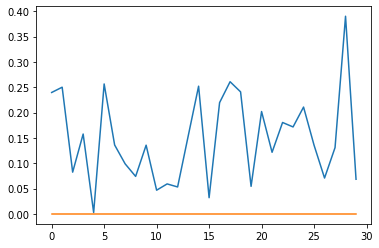

In [7]:
import matplotlib.pyplot as plt

b = []
N = 30
for i in range(N):
  b.append(GapCalc(LatticeNumber = 2,LayersNumber = 5,Field = 10*(1 - i/N), j1_k_j2 = 0.3))
plt.plot(range(N), b, np.zeros(N))
plt.show()